<a href="https://colab.research.google.com/github/porcelainruler/Kaggle/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [146]:
# ! pip install -q tensorflow
import tensorflow as tf
print(tf.__version__)

import pandas as pd
import numpy as np
import seaborn as sbs

import re

# To plot within notebook
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras import regularizers

# For normalizing data
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
scaler = MinMaxScaler(feature_range=(0, 1))

import warnings
warnings.filterwarnings('ignore')


2.3.0


In [77]:
from google.colab import files

uploaded1 = files.upload()
uploaded2 = files.upload()

Saving train.csv to train (2).csv


Saving test.csv to test (1).csv


In [105]:
import io

train = pd.read_csv(io.BytesIO(uploaded1['train.csv']))
test = pd.read_csv(io.BytesIO(uploaded2['test.csv']))

all = [train, test]

train.head()
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [23]:
'''
df = df.fillna(value=0)
# df = df.drop(columns=['Name'])
# df = df.drop(columns=['Ticket'])
print(df.iloc[0, 3])

for idx in range(len(df)):
  if df.iloc[idx, 3] == 'male':
    df.iloc[idx, 3] = 0
  else:
    df.iloc[idx, 3] = 1

  if str(df.iloc[idx, 8])[0] == 'C':
    df.iloc[idx, 8] = str(df.iloc[idx, 8])[1:]

df.head()
'''

male


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,0,22.0,1,0,7.2500,0,0
1,2,1,1,1,38.0,1,0,71.2833,85,1
2,3,1,3,1,26.0,0,0,7.9250,0,0
3,4,1,1,1,35.0,1,0,53.1000,123,0
4,5,0,3,0,35.0,0,0,8.0500,0,0


In [106]:
# Creating FamilySize Feature
for data in all:
    data['family_size'] = data['SibSp'] + data['Parch'] + 1

# Creating isAlone Feature
for data in all:
    data['is_alone'] = 0
    data.loc[data['family_size'] == 1, 'is_alone'] = 1

# NaN Value in Embarked Column
for data in all:
    data['Embarked'] = data['Embarked'].fillna('S')

# NaN Value in Fare Column
for data in all:
    data['Fare'] = data['Fare'].fillna(data['Fare'].median())
train['category_fare'] = pd.qcut(train['Fare'], 4)

# Missing Age Value Handling
for data in all:
    age_avg  = data['Age'].mean()
    age_std  = data['Age'].std()
    age_null = data['Age'].isnull().sum()

    random_list = np.random.randint(age_avg - age_std, age_avg + age_std , size = age_null)
    data['Age'][np.isnan(data['Age'])] = random_list
    data['Age'] = data['Age'].astype(int)

train['category_age'] = pd.cut(train['Age'], 5)




#Feature 7: Name
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\. ', name)
    if title_search:
        return title_search.group(1)
    return ""

for data in all:
    data['title'] = data['Name'].apply(get_title)

for data in all:
    data['title'] = data['title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'],'Rare')
    data['title'] = data['title'].replace('Mlle','Miss')
    data['title'] = data['title'].replace('Ms','Miss')
    data['title'] = data['title'].replace('Mme','Mrs')

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_size,is_alone,category_fare,category_age,title
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,2,0,"(-0.001, 7.91]","(16.0, 32.0]",Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,2,0,"(31.0, 512.329]","(32.0, 48.0]",Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1,"(7.91, 14.454]","(16.0, 32.0]",Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,2,0,"(31.0, 512.329]","(32.0, 48.0]",Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,1,1,"(7.91, 14.454]","(32.0, 48.0]",Mr


In [107]:
#Map Data
for data in all:

    #Mapping Sex
    sex_map = { 'female':0 , 'male':1 }
    data['Sex'] = data['Sex'].map(sex_map).astype(int)

    #Mapping Title
    title_map = {'Mr':1, 'Miss':2, 'Mrs':3, 'Master':4, 'Rare':5}
    data['title'] = data['title'].map(title_map)
    data['title'] = data['title'].fillna(0)

    #Mapping Embarked
    embark_map = {'S':0, 'C':1, 'Q':2}
    data['Embarked'] = data['Embarked'].map(embark_map).astype(int)

    #Mapping Fare
    data.loc[ data['Fare'] <= 7.91, 'Fare']                            = 0
    data.loc[(data['Fare'] > 7.91) & (data['Fare'] <= 14.454), 'Fare'] = 1
    data.loc[(data['Fare'] > 14.454) & (data['Fare'] <= 31), 'Fare']   = 2
    data.loc[ data['Fare'] > 31, 'Fare']                               = 3
    data['Fare'] = data['Fare'].astype(int)

    #Mapping Age
    data.loc[ data['Age'] <= 16, 'Age']                       = 0
    data.loc[(data['Age'] > 16) & (data['Age'] <= 32), 'Age'] = 1
    data.loc[(data['Age'] > 32) & (data['Age'] <= 48), 'Age'] = 2
    data.loc[(data['Age'] > 48) & (data['Age'] <= 64), 'Age'] = 3
    data.loc[ data['Age'] > 64, 'Age']                        = 4

#Feature Selection
#Create list of columns to drop
drop_elements = ["Name", "Ticket", "Cabin", "SibSp", "Parch", "family_size"]

#Drop columns from both data sets
train = train.drop(drop_elements, axis = 1)
train = train.drop(['PassengerId','category_fare', 'category_age'], axis = 1)
test = test.drop(drop_elements, axis = 1)

train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,is_alone,title
0,0,3,1,1,0,0,0,1
1,1,1,0,2,3,1,0,3
2,1,3,0,1,1,0,1,2
3,1,1,0,2,3,0,0,3
4,0,3,1,2,1,0,1,1


In [156]:
X_train = train.drop(columns=['Survived'], axis=1)
Y_train = train['Survived']
X_test  = test.drop("PassengerId", axis=1).copy()
# X.head()
# Y.head()

# X_norm = scaler.fit_transform(X)
# X_norm[1][2]

X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_train, Y_train, test_size=0.2)
x_val, x_test, y_val, y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

In [149]:
X_train
# X_test

,Pclass,Sex,Age,Fare,Embarked,is_alone,title
0,3,1,1,0,0,0,1
1,1,0,2,3,1,0,3
2,3,0,1,1,0,1,2
3,1,0,2,3,0,0,3
4,3,1,2,1,0,1,1
...,...,...,...,...,...,...,...
886,2,1,1,1,0,1,5
887,1,0,1,2,0,1,2
888,3,0,1,2,0,0,2
889,1,1,1,2,1,1,1


In [ ]:

# Data Plot
# df = sbs.load_dataset('data')
# print(sbs.pairplot(data=data))
sbs.pairplot(data=data)
plt.show()

# Data Correlation
# -- 1st Tech
plt.matshow(data.corr())
plt.show()

# -- 2nd Tech
'''
f = plt.figure(figsize=(7, 7))
plt.matshow(data.corr(), fignum=f.number)
plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=45)
plt.yticks(range(data.shape[1]), data.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);
plt.show()
'''

# -- 3rd Tech
'''
corr = data.corr()
f = plt.figure(figsize=(8,8))
corr.style.background_gradient(cmap='coolwarm')
plt.matshow(corr, fignum=f.number)
plt.show(corr)
'''


In [126]:
# Decision Tree Model
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_testFin)
accuracy = round(decision_tree.score(X_train, Y_train) * 100, 2)
print("Model Accuracy: ",accuracy)

Model Accuracy:  87.21


In [157]:
model = Sequential()
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1(0.01), input_shape=(7,)))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l1(0.01)))
model.add(Dropout(0.25))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l1(0.01)))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l1(0.01)))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_data=(x_val, y_val))

# print(model.summary())

Epoch 1/100
23/23 [==============================] - 0s 9ms/step - loss: 4.7009 - accuracy: 0.5393 - val_loss: 4.3737 - val_accuracy: 0.6292
Epoch 2/100
23/23 [==============================] - 0s 2ms/step - loss: 4.1665 - accuracy: 0.6096 - val_loss: 3.8781 - val_accuracy: 0.7079
Epoch 3/100
23/23 [==============================] - 0s 2ms/step - loss: 3.6866 - accuracy: 0.6264 - val_loss: 3.4190 - val_accuracy: 0.7079
Epoch 4/100
23/23 [==============================] - 0s 2ms/step - loss: 3.2457 - accuracy: 0.6348 - val_loss: 2.9981 - val_accuracy: 0.7079
Epoch 5/100
23/23 [==============================] - 0s 2ms/step - loss: 2.8174 - accuracy: 0.6952 - val_loss: 2.6088 - val_accuracy: 0.7079
Epoch 6/100
23/23 [==============================] - 0s 2ms/step - loss: 2.4683 - accuracy: 0.6531 - val_loss: 2.2638 - val_accuracy: 0.7528
Epoch 7/100
23/23 [==============================] - 0s 2ms/step - loss: 2.1385 - accuracy: 0.6756 - val_loss: 1.9565 - val_accuracy: 0.7528
Epoch 8/100
2

In [158]:
model.evaluate(x_test, y_test)[1]

3/3 [==============================] - 0s 2ms/step - loss: 0.5690 - accuracy: 0.8222


0.8222222328186035

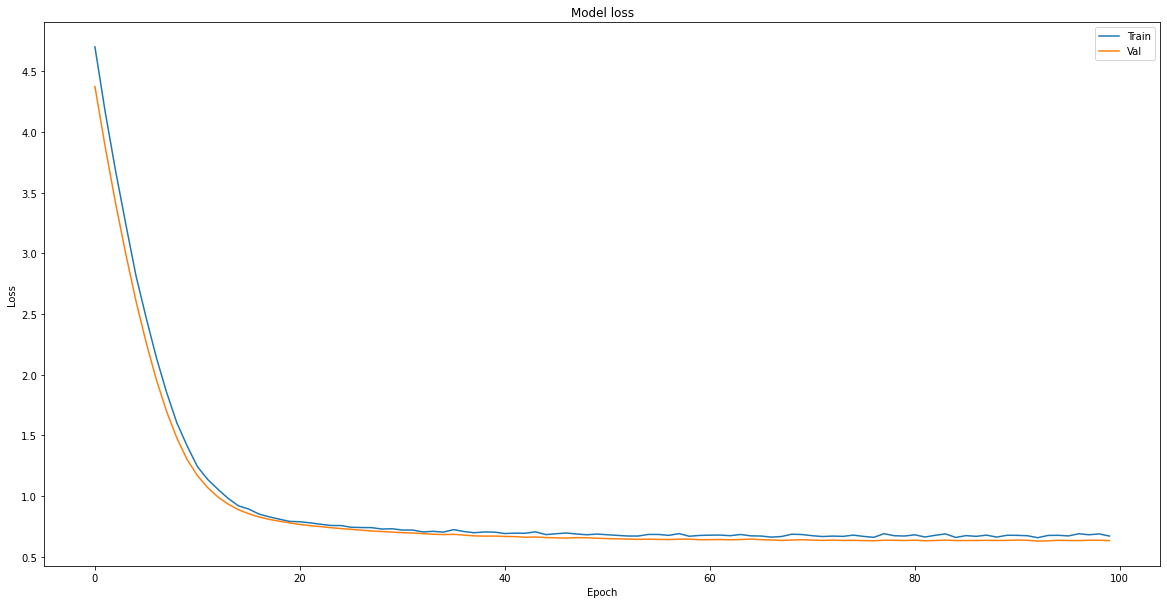

In [159]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [150]:
# Create and Fit the LSTM network - Not Working
x_train, y_train = np.array(X_train), np.array(Y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=100, batch_size=16, verbose=2)

Epoch 1/100
56/56 - 0s - loss: 5.9207 - accuracy: 0.6162
Epoch 2/100
56/56 - 0s - loss: 5.9207 - accuracy: 0.6162
Epoch 3/100
56/56 - 0s - loss: 5.9207 - accuracy: 0.6162
Epoch 4/100
56/56 - 0s - loss: 5.9207 - accuracy: 0.6162
Epoch 5/100
56/56 - 0s - loss: 5.9207 - accuracy: 0.6162
Epoch 6/100
56/56 - 0s - loss: 5.9207 - accuracy: 0.6162
Epoch 7/100
56/56 - 0s - loss: 5.9207 - accuracy: 0.6162
Epoch 8/100
56/56 - 0s - loss: 5.9207 - accuracy: 0.6162
Epoch 9/100
56/56 - 0s - loss: 5.9207 - accuracy: 0.6162
Epoch 10/100
56/56 - 0s - loss: 5.9207 - accuracy: 0.6162
Epoch 11/100
56/56 - 0s - loss: 5.9207 - accuracy: 0.6162
Epoch 12/100
56/56 - 0s - loss: 5.9207 - accuracy: 0.6162
Epoch 13/100
56/56 - 0s - loss: 5.9207 - accuracy: 0.6162
Epoch 14/100
56/56 - 0s - loss: 5.9207 - accuracy: 0.6162
Epoch 15/100
56/56 - 0s - loss: 5.9207 - accuracy: 0.6162
Epoch 16/100
56/56 - 0s - loss: 5.9207 - accuracy: 0.6162
Epoch 17/100
56/56 - 0s - loss: 5.9207 - accuracy: 0.6162
Epoch 18/100
56/56 - 0s

In [113]:
X_testFin

,Pclass,Sex,Age,Fare,Embarked,is_alone,title
0,3,1,2,0,2,1,1
1,3,0,2,0,0,0,3
2,2,1,3,1,2,1,1
3,3,1,1,1,0,1,1
4,3,0,1,1,0,0,3
...,...,...,...,...,...,...,...
413,3,1,2,1,0,1,1
414,1,0,2,3,1,1,5
415,3,1,2,0,0,1,1
416,3,1,1,1,0,1,1


In [160]:
Y = model.predict(X_test, batch_size=32)
# Y = Y_pred

out = pd.DataFrame(index=range(len(X)), columns=['PassengerID', 'Survived'])

for idx in range(len(X)):
  out.iloc[idx, 0] = X.iloc[idx, 0]
  if idx < 20:
    print(out.iloc[idx, 0], Y[idx])
  if Y[idx] > 0.5:
    out.iloc[idx, 1] = 1
  else:
    out.iloc[idx, 1] = 0

out.head(20)

892 [0.24112576]
893 [0.5297108]
894 [0.3114462]
895 [0.20186657]
896 [0.5343477]
897 [0.20680064]
898 [0.5135101]
899 [0.27061832]
900 [0.55155474]
901 [0.20067272]
902 [0.19814771]
903 [0.3473041]
904 [0.5612337]
905 [0.25880536]
906 [0.5612337]
907 [0.5612337]
908 [0.3179916]
909 [0.22411153]
910 [0.44898644]
911 [0.54653454]


,PassengerID,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [161]:
Y[:20]

array([[0.24112576],
       [0.5297108 ],
       [0.3114462 ],
       [0.20186657],
       [0.5343477 ],
       [0.20680064],
       [0.5135101 ],
       [0.27061832],
       [0.55155474],
       [0.20067272],
       [0.19814771],
       [0.3473041 ],
       [0.5612337 ],
       [0.25880536],
       [0.5612337 ],
       [0.5612337 ],
       [0.3179916 ],
       [0.22411153],
       [0.44898644],
       [0.54653454]], dtype=float32)

In [65]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [162]:
out.to_csv('titanic_NN_3D_L1-Reg_result.csv', index=False)
!cp titanic_NN_3D_L1-Reg_result.csv "drive/My Drive/"

In [69]:
print(len(out))

418
